Enter the weights for the portfolio (they must sum to 1):


Weight for TSM:  0.2
Weight for AMZN:  0.2
Weight for NVDA:  0.2
Weight for BRK.B:  0.2
Weight for REY:  0.1
Weight for STLAM:  0.1
Enter the confidence level for VaR (e.g., 0.95 for 95%):  0.95



--- Report Finale ---
Deviazione Standard Annualizzata del Portafoglio: 21.7522%
Beta del Portafoglio: -4.2652
Generic Risk del Portafoglio: -4.0155%
Specific Risk del Portafoglio: 4.8350%
Value at Risk (VaR) annualizzato (95%): -35.9588%
Massimo Drawdown Relativo: -38.9746%


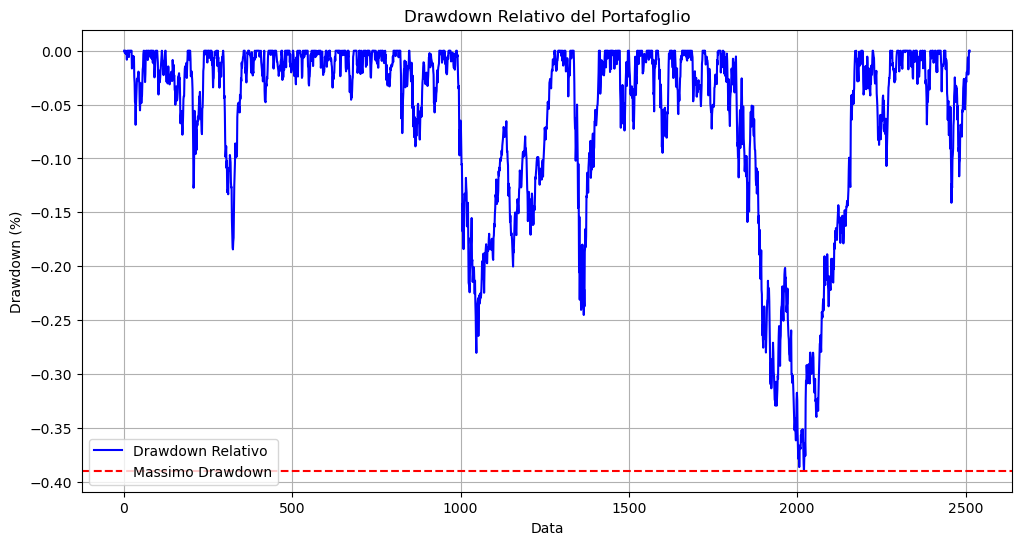

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configura i percorsi
returns_file_path = r"C:\Users\Mattia\Desktop\Task2 Risk Assessment Portfolio\Returns.xlsx"
market_file_name = "MSCI World Historical Data.xlsx"
file_directory = r"C:\Users\Mattia\Desktop\Task2 Risk Assessment Portfolio"
market_file_path = os.path.join(file_directory, market_file_name)

# Carica i dati dei rendimenti delle securities
data = pd.read_excel(returns_file_path, header=1)
returns = data.iloc[1:, 2:]  # Rimuovi le prime righe non numeriche
tickers = pd.read_excel(returns_file_path, header=1).columns[2:]  # Estrai i ticker
global asset_returns
asset_returns = returns
std_devs = returns.std()
trading_days_per_year = 252
std_devs_annualized = std_devs * (trading_days_per_year ** 0.5)

# Carica i dati dei rendimenti di mercato
if not os.path.exists(market_file_path):
    raise FileNotFoundError(f"File not found: {market_file_path}")
market_returns_df = pd.read_excel(market_file_path)
market_returns_df['Date'] = pd.to_datetime(market_returns_df['Date'])
market_returns_df = market_returns_df.sort_values(by='Date')
market_returns = market_returns_df['Change %'] / 100

# Calcola Beta, Generic Risk e Specific Risk
asset_returns.columns = tickers
betas = asset_returns.apply(lambda x: x.cov(market_returns) / market_returns.var(), axis=0)
market_std = market_returns.std()
generic_risk = betas * market_std
asset_variances = std_devs**2
specific_risk = asset_variances[:len(generic_risk)] - (generic_risk**2)

# Chiedi i pesi del portafoglio
weights = []
print("Enter the weights for the portfolio (they must sum to 1):")
for ticker in tickers:
    while True:
        try:
            weight = float(input(f"Weight for {ticker}: "))
            if weight < 0 or weight > 1:
                raise ValueError("Il peso deve essere compreso tra 0 e 1.")
            weights.append(weight)
            break
        except ValueError as e:
            print(f"Errore: {e}. Riprova.")
if not np.isclose(sum(weights), 1):
    raise ValueError(f"I pesi non sommano a 1. Totale attuale: {sum(weights):.2f}")

# Calcola statistiche di portafoglio
portfolio_beta = np.dot(betas, weights) * 100
portfolio_generic_risk = np.dot(generic_risk, weights) * 100
portfolio_specific_risk = np.dot(specific_risk, weights) * 100
portfolio_std_dev = np.sqrt(
    np.dot(weights, np.dot(asset_returns.cov() * trading_days_per_year, weights))
)

# Calcola VaR
def calculate_var(daily_returns, weights, confidence_level=0.95):
    portfolio_returns = daily_returns.dot(weights)
    daily_std_dev = portfolio_returns.std()
    annualized_std_dev = daily_std_dev * np.sqrt(252)
    z_score = abs(np.percentile(np.random.normal(0, 1, 100000), 100 * (1 - confidence_level)))
    return z_score * annualized_std_dev

confidence_level = float(input("Enter the confidence level for VaR (e.g., 0.95 for 95%): "))
var = calculate_var(asset_returns, weights, confidence_level)

# Calcola Drawdown
def calculate_relative_drawdowns(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peaks = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - peaks) / peaks
    max_drawdown = drawdowns.min()
    return drawdowns, max_drawdown

portfolio_returns = asset_returns.dot(weights)
drawdowns, max_drawdown = calculate_relative_drawdowns(portfolio_returns)

# Visualizza i risultati
print(f"\n--- Report Finale ---")
print(f"Deviazione Standard Annualizzata del Portafoglio: {portfolio_std_dev:.4%}")
print(f"Beta del Portafoglio: {portfolio_beta:.4f}")
print(f"Generic Risk del Portafoglio: {portfolio_generic_risk:.4%}")
print(f"Specific Risk del Portafoglio: {portfolio_specific_risk:.4%}")
print(f"Value at Risk (VaR) annualizzato ({confidence_level*100:.0f}%): {-var*100:.4f}%")
print(f"Massimo Drawdown Relativo: {max_drawdown:.4%}")

# Mostra Drawdown
plt.figure(figsize=(12, 6))
drawdowns.plot(label="Drawdown Relativo", color="blue")
plt.axhline(max_drawdown, color="red", linestyle="--", label="Massimo Drawdown")
plt.title("Drawdown Relativo del Portafoglio")
plt.xlabel("Data")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid()
plt.show()




